<a href="https://colab.research.google.com/github/qtannn/predict_icecream_sale/blob/main/LS_predictive_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Business Objective

1. Build a predictive model to predict sales (unit_sold)



#Thinking flow
- Is it a supervised or unsupervised model? **Supervised because it has the target - units_sold**
- Is it a regression or classification task? **Regression as the units_sold is continuous**
- Batch-learning or online learning technique? **Batch-learning**

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Get The Data

In [226]:
df = pd.read_csv("/content/drive/MyDrive/Portfolio/Luther's_Scoop/Luther_s_Scoops_Corrected_Sales_Data.csv")

#Understand the Data

In [227]:
#Understand the structure of the dataset
df.head(13)
df.info() #17532 entries, 16 columns; date is in wrong format: should be datetime
df.duplicated().sum() #no duplications
df.isna().sum() #367 NAs in units_sold and 171 NAs on total_revenue, we will handle it later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17532 entries, 0 to 17531
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    17532 non-null  object 
 1   store_id                17532 non-null  object 
 2   flavor                  17532 non-null  object 
 3   units_sold              17165 non-null  float64
 4   price_per_scoop         17532 non-null  float64
 5   total_revenue           17361 non-null  float64
 6   promotion               17532 non-null  object 
 7   promo_discount          17532 non-null  int64  
 8   weekday                 17532 non-null  object 
 9   month                   17532 non-null  int64  
 10  season                  17532 non-null  object 
 11  temperature             17532 non-null  int64  
 12  rainfall                17532 non-null  float64
 13  event                   17532 non-null  object 
 14  social_media_sentiment  17532 non-null

,0
date,0
store_id,0
flavor,0
units_sold,367
price_per_scoop,0
total_revenue,171
promotion,0
promo_discount,0
weekday,0
month,0


In [228]:
#units_sold (the target) has missing values. Regression models can't work with missing value --> need to drops them
df.dropna(subset = ["units_sold"], inplace = True)
#Check to make sure no NA at all
df["units_sold"].isna().sum()

0

In [229]:
#Since revenue is used to calculate the units_sold, these two vars are highly correlated. Keeping both will introduce data leakage
#Therefore, we need to remove "total_revenue"
df.drop(columns = "total_revenue", inplace = True)

In [230]:
#Extract date to seperate features: day and year since we already have month
df["date"] = pd.to_datetime(df["date"], format = "mixed")
#Extract
df["year"] = df["date"].dt.year
df["day"] = df["date"].dt.day
#datetime is not handled by machine learning models,  we'd better drop it
df.drop(columns=["date"], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17165 entries, 0 to 17530
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   store_id                17165 non-null  object 
 1   flavor                  17165 non-null  object 
 2   units_sold              17165 non-null  float64
 3   price_per_scoop         17165 non-null  float64
 4   promotion               17165 non-null  object 
 5   promo_discount          17165 non-null  int64  
 6   weekday                 17165 non-null  object 
 7   month                   17165 non-null  int64  
 8   season                  17165 non-null  object 
 9   temperature             17165 non-null  int64  
 10  rainfall                17165 non-null  float64
 11  event                   17165 non-null  object 
 12  social_media_sentiment  17165 non-null  float64
 13  customer_traffic        17165 non-null  int64  
 14  year                    17165 non-null  int

array([[<Axes: title={'center': 'units_sold'}>,
        <Axes: title={'center': 'price_per_scoop'}>,
        <Axes: title={'center': 'promo_discount'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'rainfall'}>],
       [<Axes: title={'center': 'social_media_sentiment'}>,
        <Axes: title={'center': 'customer_traffic'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'day'}>, <Axes: >, <Axes: >]],
      dtype=object)

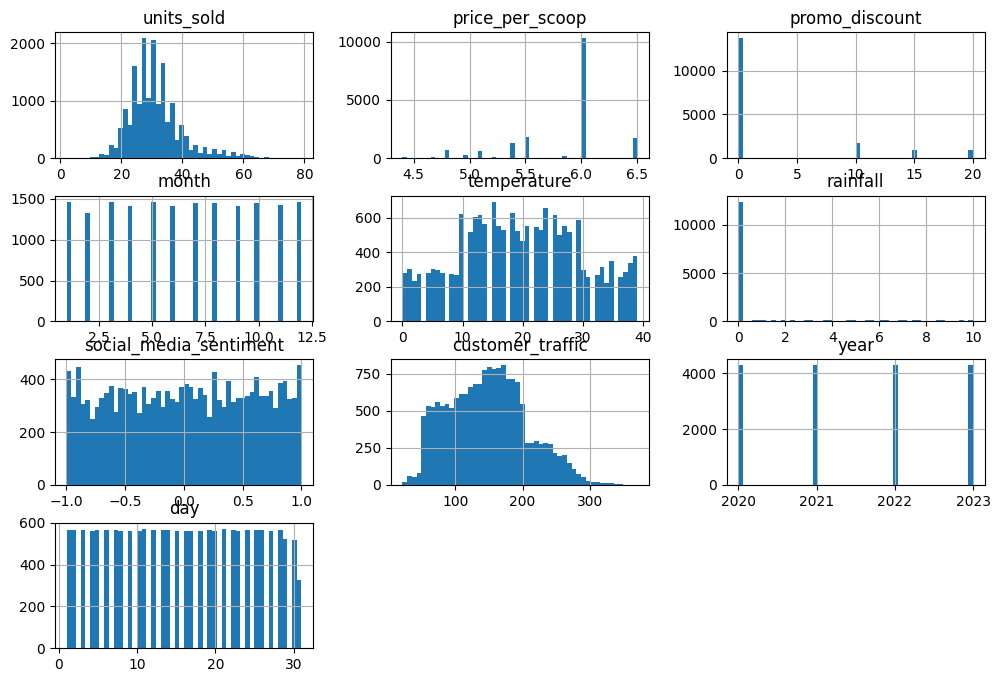

In [231]:
#Check for numerical distribution
df.hist(bins=50, figsize=(12,8))

A few things is noticeable from the histograms:
- Units_sold, and customer_traffic follow right-skewed distribution. These need to be log-transformed
- temperature is normally distributed
- social_media_sentiment has two peaks at -1 and 1.
- Most flavours are priced at 6 per scoop.
- Variables are all measured on different scale.


#Create a test set


In [232]:
from sklearn.model_selection import train_test_split

In [233]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

#Explore and visualise the data to gain some insights

In [235]:
#Put aside the test_set always
#Create a copy of the train_set to do some exploration
df = train_set.copy()

,store_id,flavor,units_sold,price_per_scoop,promotion,promo_discount,weekday,month,season,temperature,rainfall,event,social_media_sentiment,customer_traffic,year,day
1457,Brunswick,Cookies & Cream,34.0,6.0,No,0,Friday,5,Fall,19,0.000000,No,0.242731,190,2020,5
12795,Brunswick,Malted Chocolate,31.0,6.0,No,0,Friday,12,Summer,29,0.000000,No,-0.307337,163,2022,12
12642,Thornbury,Strawberry Sorbet,42.0,5.5,No,0,Saturday,11,Spring,16,0.000000,No,-0.293567,177,2022,19
8874,Thornbury,Mango Sorbet,31.0,5.5,No,0,Sunday,1,Summer,30,0.000000,No,-0.407154,205,2022,1
7626,Thornbury,Strawberry Sorbet,35.0,5.5,No,0,Monday,9,Spring,28,3.423826,No,0.966044,147,2021,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11538,Thornbury,Dark Chocolate,31.0,5.2,No,20,Friday,8,Winter,13,0.000000,No,0.080257,107,2022,19
12235,Thornbury,Lavender Honey,28.0,5.1,No,15,Sunday,10,Spring,16,0.000000,No,0.764841,179,2022,16
5520,Brunswick,Butterscotch Ripple,27.0,6.0,No,0,Monday,4,Fall,24,0.000000,No,0.449141,117,2021,4
874,Thornbury,Malted Vanilla,45.0,6.0,No,0,Friday,3,Fall,20,6.909496,Yes,-0.977826,167,2020,13


##Look for correlation

In [238]:
#Since .corr() only taks numerial var, create new df with num var only
num_df = df.select_dtypes(include = ["float64","int64", "int32"])
#Correlation matrix
corr_matrix = num_df.corr()
corr_matrix.iloc[:,0].sort_values(ascending = False)

,units_sold
units_sold,1.000000
customer_traffic,0.215840
temperature,0.032765
promo_discount,0.009464
month,0.004340
day,-0.000953
social_media_sentiment,-0.006629
price_per_scoop,-0.014681
year,-0.025488
rainfall,-0.192221


- units_sold has strong positive relationship with and customer_traffic:
    - the value of 0.22 means that more customer traffic may help boost sale. Therefore, customer_traffic may be a good variable to help predict the units_sold.

- units_sold has strong negative relationship with rainfall, suggesting that the more it rains, the lesser the sales.

array([[<Axes: xlabel='units_sold', ylabel='units_sold'>,
        <Axes: xlabel='customer_traffic', ylabel='units_sold'>,
        <Axes: xlabel='rainfall', ylabel='units_sold'>],
       [<Axes: xlabel='units_sold', ylabel='customer_traffic'>,
        <Axes: xlabel='customer_traffic', ylabel='customer_traffic'>,
        <Axes: xlabel='rainfall', ylabel='customer_traffic'>],
       [<Axes: xlabel='units_sold', ylabel='rainfall'>,
        <Axes: xlabel='customer_traffic', ylabel='rainfall'>,
        <Axes: xlabel='rainfall', ylabel='rainfall'>]], dtype=object)

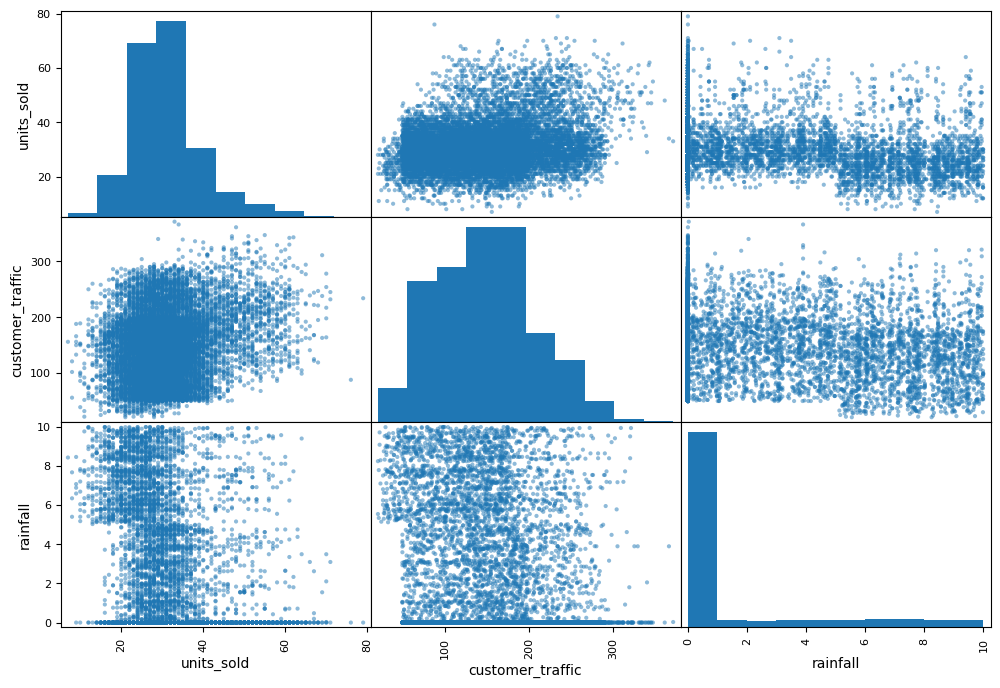

In [239]:
#I will use scatter plot to visualise these relationships
from pandas.plotting import scatter_matrix
high_corr = ["units_sold", "customer_traffic", "rainfall"]
scatter_matrix(df[high_corr],figsize=(12,8))

#Data Preparation for Machine Learning Algorithms

In [284]:
#Isolate the target and predictors
##train_set
train_target = train_set["units_sold"].copy()
train_set = train_set.drop(columns = "units_sold")
##test_set
test_target = test_set["units_sold"].copy()
test_set = test_set.drop(columns = "units_sold")

,store_id,flavor,price_per_scoop,promotion,promo_discount,weekday,month,season,temperature,rainfall,event,social_media_sentiment,customer_traffic,year,day
3795,Brunswick,Malted Chocolate,6.0,No,0,Thursday,11,Spring,19,0.000000,No,0.124146,82,2020,11
2578,Thornbury,Malted Vanilla,6.0,No,0,Sunday,8,Winter,7,0.000000,No,-0.967693,261,2020,8
5983,Thornbury,Pumpkin Spice,6.0,No,0,Thursday,5,Fall,10,2.459158,No,-0.143665,142,2021,13
12110,Brunswick,Lemon Tart,6.0,No,0,Thursday,10,Spring,21,0.000000,No,0.881424,143,2022,10
12114,Thornbury,Strawberry Sorbet,5.5,No,0,Thursday,10,Spring,22,4.117246,Yes,-0.841962,122,2022,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10828,Brunswick,Malted Vanilla,5.4,No,10,Tuesday,6,Winter,14,0.000000,No,-0.139222,62,2022,21
14113,Brunswick,Pumpkin Spice,6.0,No,0,Wednesday,3,Fall,15,0.000000,No,0.994466,51,2023,22
6035,Thornbury,Cookies & Cream,6.0,No,0,Monday,5,Fall,18,0.000000,No,0.616282,89,2021,17
12886,Thornbury,Malted Vanilla,6.0,No,0,Friday,12,Summer,37,0.000000,No,0.923590,181,2022,12


**Step-by-Step Manual Process**
- Step 1: Identify missing values & handle them (imputation) with SimpleImputer
- Step 2: Remove duplicates & handle outliers.
- Step 3: Feature engineering (create new features).
- Step 4: Encode categorical variables using OneHotEncoding
- Step 5: Scale numerical features using StandardScaler or MinMaxScaler.
- Step 6: Apply the same transformations to the test set (without refitting).

However, in this notebook, the transformation pipeline is used to avoid tediousness and mistakes.

##Step-by-Step Breakdown of the Transformation Pipeline


###1. Define the Steps Needed for Preprocessing

- Handling missing values (imputation)
- Scaling numerical features
- Encoding categorical variables
- Feature engineering (optional)


###2. Create a Pipeline for Numerical Features

In [285]:
train_set_num = train_set.select_dtypes(include = ["int64", "float64", "int32"])

,price_per_scoop,promo_discount,month,temperature,rainfall,social_media_sentiment,customer_traffic,year,day
1457,6.0,0,5,19,0.000000,0.242731,190,2020,5
12795,6.0,0,12,29,0.000000,-0.307337,163,2022,12
12642,5.5,0,11,16,0.000000,-0.293567,177,2022,19
8874,5.5,0,1,30,0.000000,-0.407154,205,2022,1
7626,5.5,0,9,28,3.423826,0.966044,147,2021,27
...,...,...,...,...,...,...,...,...,...
11538,5.2,20,8,13,0.000000,0.080257,107,2022,19
12235,5.1,15,10,16,0.000000,0.764841,179,2022,16
5520,6.0,0,4,24,0.000000,0.449141,117,2021,4
874,6.0,0,3,20,6.909496,-0.977826,167,2020,13


In [250]:
#Handle missing values, log transformation, and scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#Create pipeline for num features
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("scaler", StandardScaler())
])


###3. Create a Pipeline for Categorical Features

In [251]:
from sklearn.preprocessing import OneHotEncoder

In [286]:
train_set_cat = train_set.select_dtypes(include = "object")

,store_id,flavor,promotion,weekday,season,event
1457,Brunswick,Cookies & Cream,No,Friday,Fall,No
12795,Brunswick,Malted Chocolate,No,Friday,Summer,No
12642,Thornbury,Strawberry Sorbet,No,Saturday,Spring,No
8874,Thornbury,Mango Sorbet,No,Sunday,Summer,No
7626,Thornbury,Strawberry Sorbet,No,Monday,Spring,No
...,...,...,...,...,...,...
11538,Thornbury,Dark Chocolate,No,Friday,Winter,No
12235,Thornbury,Lavender Honey,No,Sunday,Spring,No
5520,Brunswick,Butterscotch Ripple,No,Monday,Fall,No
874,Thornbury,Malted Vanilla,No,Friday,Fall,Yes


In [255]:
cat_pipeline = Pipeline([
    ("cat_imputer", SimpleImputer(strategy = "most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

###4. Create a Full Pipeline for Both Numerical & Categorical Features

In [182]:
from sklearn.compose import ColumnTransformer

In [257]:
#Define num columns and cat columns
num_features = list(train_set_num.columns)
cat_features = list(train_set_cat.columns)

#Combine 2 pipelines
full_pipeline = ColumnTransformer([
    ("num", num_pipeline,num_features),
    ("cat", cat_pipeline, cat_features)
])


###5. Fit and Transform the Training Data

In [288]:
train_prepared = full_pipeline.fit_transform(train_set)
train_prepared.shape

(13732, 42)

###6. Apply the Same Pipeline to the Test Set (without refitting)

In [264]:
test_prepared = full_pipeline.fit_transform(test_set)
test_prepared.shape

(3433, 42)

#Train and Evaluate on the Training Set

##1. Train by baseline models

In [289]:
#Start with basic linear regression
from sklearn.linear_model import LinearRegression
#Train the model
lin_reg = LinearRegression()
lin_reg.fit(train_prepared,train_target)

LinearRegression()

In [294]:
#Make predictions on the training set
train_prediction = lin_reg.predict(train_prepared)

#Comparing predicted values versus actual values
print(f'Predicted value: {train_prediction[:5].round(0)}')
print(f'Actual value: {train_target.iloc[:5].values}')


array([[ 0.38713877, -0.47365948, -0.44023554, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.38713877, -0.47365948,  1.59082763, ...,  0.        ,
         1.        ,  0.        ],
       [-0.78406543, -0.47365948,  1.30067575, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.38713877, -0.47365948, -0.73038743, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.38713877, -0.47365948, -1.02053931, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38713877, -0.47365948,  0.72037199, ...,  0.        ,
         1.        ,  0.        ]])

In [293]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(train_target, train_prediction))
print(f"Training RMSE: {rmse}")
train_target.describe()
"""
#The RMSE is not too high but it is neither a great score. Why?
#Because most of the units_sold values are in the range 26-35,
a typical prediction error of nearly 6 units is not satisfying
"""

array([30.48533489, 29.98975645, 30.62349212, ..., 30.21859529,
       45.45160152, 24.1520782 ])

In [271]:
#Try Decision Tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_prepared, train_target)

#Predict and evaluate
train_prediction_tree = tree_reg.predict(train_prepared)
tree_rmse = np.sqrt(mean_squared_error(train_target, train_prediction_tree))
print(f"Decision Tree Training RMSE: {tree_rmse}")
#RMSE is 0, badly overfitting

Decision Tree Training RMSE: 0.0


In [272]:
#Use cross-validation: split the train-test and train it for 10 times

from sklearn.model_selection import cross_val_score

scores_tree = -cross_val_score(tree_reg, train_prepared, train_target, scoring = "neg_root_mean_squared_error", cv = 10)

pd.Series(scores_tree).describe()
#The RMSE now is even higher than the linear's RMSE

,0
count,10.000000
mean,8.526788
std,0.154253
min,8.237905
25%,8.439932
50%,8.548435
75%,8.629993
max,8.766251


In [299]:
#Train a random forest model
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(train_prepared, train_target)

##Cross-validation
scores_forest = -cross_val_score(forest_reg, train_prepared, train_target, scoring = "neg_mean_squared_error", cv=10)

pd.Series(scores_forest).describe()

#The RMSE is too high now, indicating sign of underfitting

,units_sold
1457,34.0
12795,31.0
12642,42.0
8874,31.0
7626,35.0
...,...
11538,31.0
12235,28.0
5520,27.0
874,45.0


##Best performing model: Linearn Regression
Next steps:
- Evaluate the model on test set
- Identify feature importance for business insights

In [304]:
#Evaluate model on the test set.
test_prediction = lin_reg.predict(test_prepared)

final_rmse = np.sqrt(mean_squared_error(test_target, test_prediction))
print(rmse)
print(final_rmse)
##The RMSE of LR on train set (5.9) and on test set (6.0) is very much the same --> the model generalises well.

5.926019369484359
6.023278087066375


In [320]:
#Look at feature importance
index_name = list(full_pipeline.get_feature_names_out())
feature_importance = pd.DataFrame(lin_reg.coef_, index=index_name, columns=["Coefficient"])
print(feature_importance.sort_values(by = "Coefficient", ascending = False))


                                            Coefficient
cat__event_Yes                                 9.723159
cat__flavor_Lavender Honey                     0.371702
cat__flavor_Caramel Pecan                      0.364404
cat__flavor_Hot Cocoa Fudge                    0.332795
cat__season_Fall                               0.308097
cat__flavor_Cookies & Cream                    0.241177
cat__weekday_Saturday                          0.236610
cat__weekday_Monday                            0.175192
cat__flavor_Dark Chocolate                     0.168288
cat__weekday_Sunday                            0.166883
cat__flavor_Malted Vanilla                     0.162496
cat__promotion_No                              0.134167
cat__flavor_Malted Chocolate                   0.103124
cat__promotion_Yes                             0.057478
cat__store_id_Thornbury                        0.024862
num__day                                       0.014726
cat__weekday_Wednesday                         0

#Business Insights and Recommendations

**Insights from the Feature Importance Report**
1. Positively Influenced Factors
- Events significantly boost sales (+9.72)
- Lavender Honey, Caramel Pecan, and Hot Cocoa Fudge are more popular than other flavours which are strongly linked to higher sales
- Sales slightly increases during fall
- *MOST SURPRISING*: not running a promotion correlates with higher sales more than running a promotion (in this case, specific promotion types analysis may be needed to address why)

2. Negatively Influenced Factors
- No event is associated with sales dropped
- More rain means fewer sales
- Pumpkin Spice and Mago Sorbet are not popular flavors
- Lower sales on Thursday
- Higher prices reduce sales.
    - LS customers are price-sensitive and they may switch to competitors that have cheaper ice-cream.
    - Moreover, LS has been building the brand image of "your friendly neighborhood", offering higher price with no justification may cause customers' resistance.
- Sales drop in winter


**Recommendations**
- As events boost sales massively, LS should:
    - Actively participate in local events and festivals/food markets
    - Prioritise marketing and stocking for event days
- With certain flavours driving sales, LS should highlight them in promotions and on social media channels while reconsider stocking essessively for unpopular flavours.
- Since demands are fluctuated seasonally (lower sales in winter and higher sales in fall), LS should adjust inventory and marketing efforts accordingly.
- As rain negatively impacts sales, LS should have delivery options on rainy days (focusing on take-home purchases)
- As higher prices hurt sale, LS should be mindful increasing price with justification only.
- Further analysis is needed to discover why not having a promotion generates more sales than having a promotion.